In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import os
# Change working directory to the root of the project, try to be cautious with this implementation since it will break if the cell is run more than once
os.chdir(r"../..")

import pandas as pd
from resources.constants import *
from src import load_dataframes

outfits_df = load_dataframes.load_pickle(DATA_SAVE_PATH, OUTFITS_PATH)
pictures_df = pd.read_csv(PICTURE_TRIPLETS_CSV_PATH, sep=CSV_SEPARATOR)
user_triplets_df = pd.read_csv(USER_ACTIVITY_TRIPLETS_CSV_PATH, sep=CSV_SEPARATOR)
# For the purposes of this notebook, we're not interested in duplicate outfits
outfits_df = outfits_df.groupby("group").first().reset_index()

In [2]:
import numpy as np

def get_outfit_category(tag_categories, tags, category):
    tag_categories, tags = np.array(tag_categories), np.array(tags)
    category_indexes = np.where(tag_categories == category)[0]
    if len(category_indexes) == 0:
        return []
    cat_tags = tags[category_indexes]
    return cat_tags

outfits_df["category"] = outfits_df.apply(lambda x: get_outfit_category(x["tag_categories"], x["outfit_tags"], "Category"), axis=1)
outfit_category_dict = outfits_df[["id", "category"]].set_index("id").to_dict()["category"]

In [3]:
user_rentals_df = user_triplets_df.groupby("customer.id").agg({"outfit.id": list}).reset_index()

In [5]:
def get_outfit_categories(outfit_ids, outfits_to_categories):
    return [category for outfit_id in outfit_ids for category in outfits_to_categories.get(outfit_id, [])]

user_rentals_df["outfit_categories"] = user_rentals_df["outfit.id"].apply(lambda x: get_outfit_categories(x, outfit_category_dict))
user_rentals_df["num_rentals"] = user_rentals_df["outfit.id"].apply(len)

In [6]:

# Calculate Simpson Diversity Index, measuring the probability that two items randomly selected from the dataset will be of different categories
def calculate_simpson_diversity(categories):
    categories = np.array(categories)
    unique_categories, category_counts = np.unique(categories, return_counts=True)
    category_probs = category_counts / category_counts.sum()
    return 1 - np.sum(category_probs ** 2)

def simpson_di(categories):

    """ Given a hash { 'species': count } , returns the Simpson Diversity Index
    
    >>> simpson_di({'a': 10, 'b': 20, 'c': 30,})
    0.3888888888888889
    """

    def p(n, N):
        if n ==  0:
            return 0
        else:
            return float(n)/N

    unique_categories, category_counts = np.unique(categories, return_counts=True)
    N = sum(category_counts)
    
    return sum(p(n, N)**2 for n in category_counts if n != 0)

#user_rentals_df["simpson_diversity"] = user_rentals_df["outfit_categories"].apply(calculate_simpson_diversity)
user_rentals_df["simpson_diversity"] = user_rentals_df["outfit_categories"].apply(simpson_di)
user_rentals_df[user_rentals_df["num_rentals"] > 4]["simpson_diversity"].mean()

0.2865477913227337

In [7]:
import pickle

# Load pre-computed embeddings from pickle to outfits_df

PICKLED_DICT_PATH = r"resources\data\dataset\embeddings\EfficientNet_V2_L_final_dict.pkl"
with open(PICKLED_DICT_PATH, "rb") as f:
    embeddings_dict = pickle.load(f)

pictures_df["embedding"] = pictures_df["picture.id"].apply(lambda x: embeddings_dict[x])
# Sort displayorder beforehand to ensure embeddings are in the correct order
pictures_dict = pictures_df.sort_values("displayOrder").groupby("outfit.id").agg({"embedding": list, "displayOrder":list, "picture.id": list}).to_dict()
outfits_to_embeddings_dict = pictures_dict["embedding"]
outfits_to_pictures_id_dict = pictures_dict["picture.id"]
outfits_df["embeddings"] = outfits_df["id"].apply(lambda x: outfits_to_embeddings_dict.get(x, []))
outfits_df["picture_ids"] = outfits_df["id"].apply(lambda x: outfits_to_pictures_id_dict.get(x, []))
outfits_df["num_pictures"] = outfits_df["embeddings"].apply(len)
# Use the first picture as the a representative embedding for the outfit
outfits_df["lead_embedding"] = outfits_df["embeddings"].apply(lambda x: x[0] if len(x) > 0 else None)
outfits_df["lead_picture_id"] = outfits_df["picture_ids"].apply(lambda x: x[0] if len(x) > 0 else None)
print(f"{len(outfits_df[outfits_df['num_pictures'] == 0])} of {len(outfits_df)} outfits have no embeddings")

330 of 9791 outfits have no embeddings


c:\Users\kaborg15\AppData\Local\anaconda3\envs\baseline-env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
c:\Users\kaborg15\AppData\Local\anaconda3\envs\baseline-env\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\kaborg15\AppData\Local\anaconda3\envs\baseline-env\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


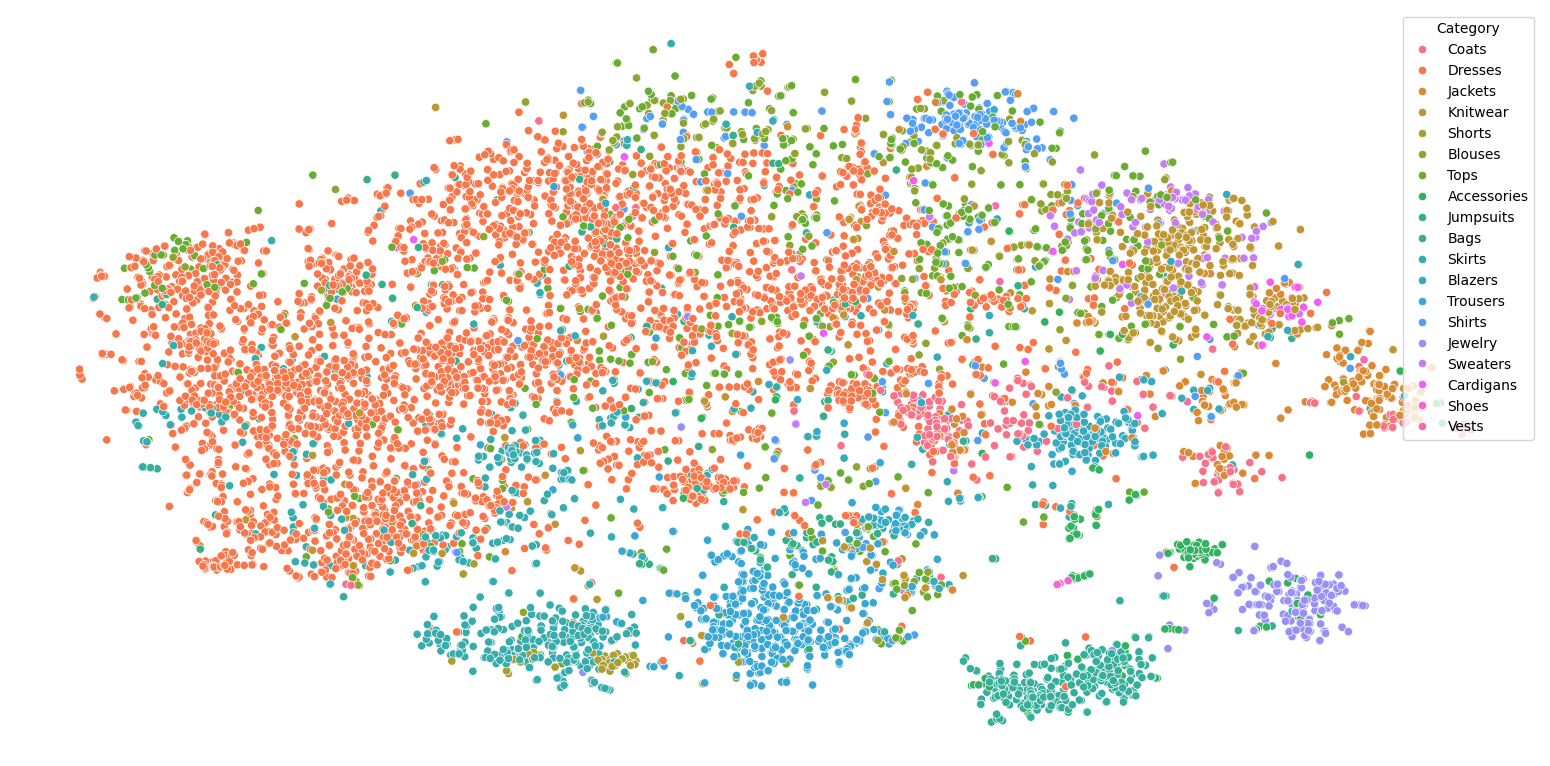

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

embeddings = np.array(outfits_df["lead_embedding"].dropna().values.tolist())
ids = outfits_df.dropna(subset=["lead_embedding"])["id"].values


tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])



tsne_df["id"] = ids
tsne_df = tsne_df.merge(outfits_df[["id", "category", "lead_picture_id"]], on="id").reset_index()
tsne_df["category"] = tsne_df["category"].apply(lambda x: x[0] if len(x) > 0 else None)



plt.figure(figsize=(16, 8))
scatter_plot = sns.scatterplot(x='TSNE1', y='TSNE2', hue='category', data=tsne_df)
plt.title(None)
plt.xlabel(None)
plt.ylabel(None)
plt.legend(title='Category')
sns.despine()
plt.tight_layout()
plt.axis('off')

FIGURE_SAVE_PATH = "reports/figures/outfit_tsne.png"
plt.savefig(FIGURE_SAVE_PATH, bbox_inches='tight')
plt.show()


In [23]:
from PIL import Image, ImageDraw 

# Use information from the scatter plot to map t-SNE coordinates to image coordinates

image = Image.open(FIGURE_SAVE_PATH)
image_width, image_height = image.size

x_min, x_max = scatter_plot.get_xlim()
y_min, y_max = scatter_plot.get_ylim()

def tsne_to_image_coordinates(tsne_x, tsne_y, img_width, img_height, x_min, x_max, y_min, y_max):
    img_x = ((tsne_x - x_min) / (x_max - x_min)) * img_width
    img_y = img_height - ((tsne_y - y_min) / (y_max - y_min)) * img_height
    return int(img_x), int(img_y)

# example_tsne_x, example_tsne_y = -0, -0
# img_x, img_y = tsne_to_image_coordinates(example_tsne_x, example_tsne_y, image_width, image_height, x_min, x_max, y_min, y_max)

# print(f"t-SNE coordinates: ({example_tsne_x}, {example_tsne_y})")
# print(f"Image coordinates: ({img_x}, {img_y})")

# draw = ImageDraw.Draw(image) 

# draw.line(xy=(img_x, 0, img_x, image_height), 
#           fill=(0, 128, 0), width = 5) 

# draw.line(xy=(0, img_y, image_width, img_y), 
#           fill=(0, 128, 0), width = 5) 

# image.show()

In [19]:
from tqdm.notebook import tqdm

IMAGES_PATH = r"resources\data\dataset\images"
MAX_IMAGE_WIDTH, MAX_IMAGE_HEIGHT = 32, 256

# test_image = Image.open(os.path.join(IMAGES_PATH, tsne_df["lead_picture_id"].iloc[8]))
# test_image.thumbnail((MAX_IMAGE_WIDTH, MAX_IMAGE_HEIGHT))
# image.paste(test_image, (img_x, img_y))
# image.show()
def paste_thumbnail_on_image(image, thumbnail_path, x, y, max_width, max_height):
    thumbnail = Image.open(thumbnail_path)
    thumbnail.thumbnail((max_width, max_height))
    image.paste(thumbnail, (x, y))
    return image

for row in tqdm(tsne_df.sample(1000).itertuples()):
    image_path = os.path.join(IMAGES_PATH, row.lead_picture_id)
    img_x, img_y = tsne_to_image_coordinates(row.TSNE1, row.TSNE2, image_width, image_height, x_min, x_max, y_min, y_max)
    image = paste_thumbnail_on_image(image, image_path, img_x, img_y, MAX_IMAGE_WIDTH, MAX_IMAGE_HEIGHT)

0it [00:00, ?it/s]

In [24]:
for row in tqdm(tsne_df.itertuples()):
    image_path = os.path.join(IMAGES_PATH, row.lead_picture_id)
    img_x, img_y = tsne_to_image_coordinates(row.TSNE1, row.TSNE2, image_width, image_height, x_min, x_max, y_min, y_max)
    try:
        image = paste_thumbnail_on_image(image, image_path, img_x, img_y, MAX_IMAGE_WIDTH, MAX_IMAGE_HEIGHT)
    except:
        continue

0it [00:00, ?it/s]

In [26]:
image.show()

In [27]:
image.close()

In [155]:
outfits_df

,id,name,description,group,owner,timeCreated,retailPrice,meta.validTo,outfit_tags,tag_categories,Outfit_size,category,embeddings,num_pictures,lead_embedding
73868,outfit.fffdaa715c3646f8b1c0f04d549ff07e,Out of stock - Asymmetric Frilled Dress,"This fun, short dress features and asymmetric ...",group.50a586c78eb7626e294ba3bd07d12c79,user.8c5d7c8f0f91598d,2017-12-30 11:28:01.000,4000.0000,9999-01-01 00:00:00,"[Metallic, Synthetic, Cotton, Sandro, Dresses,...","[Details, Material, Material, Brand, Category,...",[S],[Dresses],"[[1.738, -0.0944, -0.0934, 0.1979, 0.2365, -0....",7,"[1.738, -0.0944, -0.0934, 0.1979, 0.2365, -0.0..."
73864,outfit.fffa1b9a3db6415d806f3c48f8ab58d9,Yellow Shell Mellomholmene Blouse,This beautiful blouse features an adjustable n...,group.61ad2fcabb3e9197e3836376e6b67f2c,user.2faa21d6a80040ff9688ff45dca7b5b4,2021-06-07 12:07:22.921,1300.0000,9999-01-01 00:00:00,"[Yellow, Cotton, Blouses, Everyday, M, Summer,...","[Color, Material, Category, Occasion, Size, Se...",[M],"[Blouses, Tops]","[[-0.0843, -0.0567, -0.05966, -0.077, 1.166, -...",5,"[-0.0843, -0.0567, -0.05966, -0.077, 1.166, -0..."
73856,outfit.fff175b13ceb453f9928625491412ede,Kaula Dress Black,Kaula from Rodebjer is a fitted dress made in ...,group.37c2b59d63d3a9c2d58e07f532f71f7f,user.77113189894142f59c4a3a6278015554,2023-06-05 09:17:59.004,3100.0000,9999-01-01 00:00:00,"[Synthetic, Multi Season, Rodebjer, Everyday, ...","[Material, Seasons, Brand, Occasion, Size, Cat...",[M],[Dresses],"[[1.27, -0.0494, -0.02313, -0.1021, 0.2625, 0....",4,"[1.27, -0.0494, -0.02313, -0.1021, 0.2625, 0.2..."
73854,outfit.ffef9d7c292a48b69076d2df2e32352f,For sale - Jarvis Blouse,This wrap blouse has mid length sleeves and a ...,group.dfcaa57546b0b7a5e9eb204449b6cc1c,user.8786114165114ea0b6fbc447deae9114,2021-05-18 14:02:28.690,1500.0000,9999-01-01 00:00:00,"[Cotton, Multi Season, Floral, Wrap, XS, Style...","[Material, Seasons, Details, Fit, Size, Brand,...",[XS],[Tops],"[[-0.04453, -0.08777, -0.0676, -0.07196, 0.086...",2,"[-0.04453, -0.08777, -0.0676, -0.07196, 0.0860..."
73848,outfit.ffeef842238f4dbdabc6c730a75aa2bd,Black Amber Pants,"Feel slack and nice dressed with this pant, ma...",group.ee297c977905eb21a123a4aea5fbb6d2,user.5ab3daf28ecc4c5c9c5d2b6e37b97712,2021-07-16 14:02:30.643,1200.0000,9999-01-01 00:00:00,"[Winter, Cotton, L, Knitwear, Everyday, Fall, ...","[Seasons, Material, Size, Category, Occasion, ...",[L],"[Knitwear, Trousers]","[[0.02425, -0.1558, -0.1343, -0.07513, -0.0170...",3,"[0.02425, -0.1558, -0.1343, -0.07513, -0.01701..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,outfit.001bf665330140cf854dcfb1cbff6b5f,Out of stock - Harley Vintage White Midi Dress,This gorgeous dress is cut in the most flatter...,group.d91a2a6728833c8082dadf27b95488a9,user.91fee3d03276efed,2019-06-25 10:13:55.000,3800.0000,9999-01-01 00:00:00,"[Viscose, L, Midi, Dresses, White, Formal, Pia...","[Material, Size, Length, Category, Color, Occa...",[L],[Dresses],"[[-0.10986, -0.05212, -0.04785, -0.1338, 0.035...",6,"[-0.10986, -0.05212, -0.04785, -0.1338, 0.0359..."
11,outfit.0018701ce6b049ebadc314d16623caa8,Vintage Burberry Trench Coat,You really can't go wrong with this Classic Tr...,group.6be510229d0f9faf5d19d52e7e2b2a95,user.b0485ebe4a4b46ccb68cbe187fe101df,2023-02-07 07:54:06.214,22000.0000,2023-02-07 08:54:06.214000,"[Winter, Cotton, Midi, Everyday, Fall, Burberr...","[Seasons, Material, Length, Occasion, Seasons,...",[S],[Coats],"[[0.9565, 0.6475, -0.0587, 0.704, 0.2399, 0.04...",3,"[0.9565, 0.6475, -0.0587, 0.704, 0.2399, 0.045..."
10,outfit.0014a5c89b244077a3d7cffd4549718e,Mira Skirt Brown,The Mira Skirt in Brown from Stine Goya is an ...,group.668be5db7976aa2cb9213dd4c7f9b7fe,user.7fdc9782d70e402eb52a4e3b9808d806,2023-10-09 09:12:14.631,1500.0000,9999-01-01 00:00:00,"[Viscose, Midi, Skirts, Summer, Stine Goya, Ev...","[Material, Length, Category, Seasons, Brand, B...",[S],[Skirts],"[[-0.1237, -0.03632, -0.08435, -0.1036, 1.478,...",3,"[-0.123